<a href="https://colab.research.google.com/github/IntroComputationalPhysics-UNT/kapitza-pendulum-BraydenMittag/blob/main/Kapitza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # kapitza_pendulum
  ## y[0] = theta, y[1] = theta' (angular velocity)
  dtheta = y[1]
  dtheta' = -2 * zeta * y[1] - (epsilon**2 - alpha * cos(t)) * sin(y[0])
  RETURN [dtheta, dtheta']

FUNCTION run_simulation(epsilon, alpha, zeta, t_final, initial_conditions):
  ## Use an ODE solver (e.g., SciPy's solve_ivp) to solve the system over the time range [0, t_final]
  solution = solve_ivp(kapitza_pendulum_ode, [0, t_final], initial_conditions, args=(epsilon, alpha, zeta), dense_output=False, rtol=1e-3, atol=1e-3)
  
  ## The function should return the solution object containing time (solution.t) and angles (solution.y[0])
  RETURN solution

FUNCTION stability_diagnostic(time_series_theta, tau_transient, time_series_tau):
  ## Discard initial transients by filtering data points where tau > tau_transient
  ## Calculate average absolute angle after the transient phase
  filter_mask = time_series_tau > tau_transient
  if data_exists(filter_mask):
    average_abs_theta = mean(|theta(tau)|) for filtered tau
  else:
    average_abs_theta = 999 # Indicate a likely unstable/failed run

  RETURN average_abs_theta

MAIN SCRIPT:
  DEFINE constants: zeta, tau_final, tau_transient, initial_conditions (theta_0 slightly > 0)
  CREATE grid for epsilon values (x-axis)
  CREATE grid for alpha values (y-axis)

  INITIALIZE results matrix (size: len(alpha_grid) x len(epsilon_grid))

  FOR each alpha in alpha_grid:
    FOR each epsilon in epsilon_grid:
      solution = run_simulation(epsilon, alpha, zeta, tau_final, initial_conditions)
      
      IF solution was successful:
        diagnostic_value = stability_diagnostic(solution.y[0], tau_transient, solution.t)
      ELSE:
        diagnostic_value = 999

      STORE diagnostic_value in results matrix[alpha_index, epsilon_index]

  PLOT results matrix (heatmap with epsilon on X, alpha on Y, color showing diagnostic_value)
  PROPOSE a simple functional form for the boundary (e.g., alpha_c = C * epsilon^2)
  SUPERIMPOSE the guessed curve on the plot
  ADD a contour line based on a threshold of the diagnostic results to highlight the numerical boundary
  DISPLAY plot

<>:113: SyntaxWarning: invalid escape sequence '\z'
<>:113: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipython-input-3744408375.py:113: SyntaxWarning: invalid escape sequence '\z'
  plt.title(f'Stability Map for Kapitza Pendulum ($\zeta={ZETA}$)')


Starting parameter sweep with zeta=0.1, integrating up to tau=1000.


Sweeping Alpha:   0%|          | 0/40 [00:00<?, ?it/s]

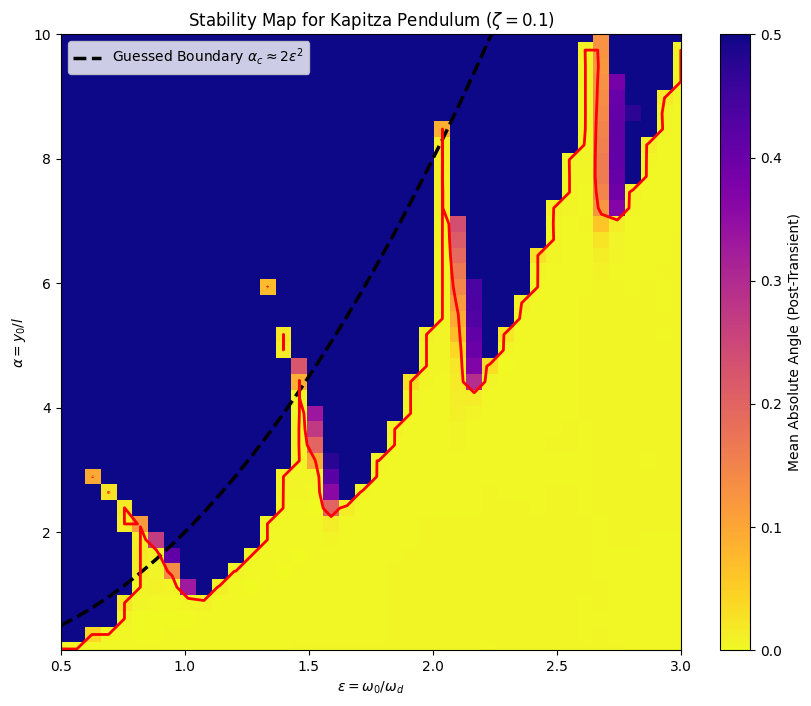


Brief comment on results:
The 2D plot shows stable regions (dark blue, low mean angle) and unstable regions (yellow/red, high mean angle).
The dashed black line represents our guessed boundary: alpha_c ~ 2.0 * epsilon^2.
The red contour line shows a numerical approximation of the transition boundary based on our diagnostic.
The guess provides a good qualitative fit, but the exact value of C varies slightly with epsilon, especially at lower frequencies.


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd


# 1. Define the ODE system


def kapitza_pendulum_ode(tau, y, epsilon, alpha, zeta):
    """
    Defines the first-order ODE system for the Kapitza pendulum.
    y[0] = theta, y[1] = d(theta)/d(tau)
    """
    theta = y[0]
    dtheta_dt = y[1]
    ddtheta_dt2 = -2 * zeta * y[1] - (epsilon**2 - alpha * np.cos(tau)) * np.sin(y[0])
    return [dtheta_dt, ddtheta_dt2]


# 2. Stability Diagnostic Function


def stability_diagnostic(tau_series, theta_series, tau_transient):
    """
    Quantifies stability by calculating the long-time average of the
    absolute angle after discarding the transient phase.

    A value close to 0 indicates stability (pendulum stays near top).
    A larger value indicates instability (pendulum falls down).
    """
    # Find indices after the transient period
    mask = tau_series >= tau_transient
    if np.any(mask):
        long_time_theta = theta_series[mask]
        # Use a simple metric: the mean absolute deviation from the inverted position (theta=0)
        mean_abs_theta = np.mean(np.abs(long_time_theta))
        return mean_abs_theta
    else:
        # If simulation finished before transient time, assume instability or issue
        return 999.0 # Placeholder for error/major instability


# 3. Parameter Sweeping Function


def sweep_parameters(eps_grid, alpha_grid, zeta, tau_final, tau_transient, initial_conditions):
    """
    Runs simulations for all combinations of epsilon and alpha.
    """
    diagnostic_results = np.zeros((len(alpha_grid), len(eps_grid)))

    # Use tqdm for progress bar in Colab
    for i, alpha in enumerate(tqdm(alpha_grid, desc="Sweeping Alpha")):
        for j, epsilon in enumerate(eps_grid):
            # Run simulation
            sol = solve_ivp(
                kapitza_pendulum_ode,
                [0, tau_final],
                initial_conditions,
                args=(epsilon, alpha, zeta),
                dense_output=False,
                # Use 'RK45' as a standard solver, could tune for performance if needed
                rtol=1e-3, atol=1e-3
            )

            # Apply diagnostic
            if sol.success:
                diag_val = stability_diagnostic(sol.t, sol.y[0], tau_transient)
            else:
                # Handle cases where solver failed (often very unstable systems)
                diag_val = 999.0

            diagnostic_results[i, j] = diag_val

    return diagnostic_results


# 4. Main execution and plotting


if __name__ == '__main__':
    # --- Configuration ---
    ZETA = 0.1  # Fixed dimensionless damping coefficient
    TAU_FINAL = 1000  # Total integration time (dimensionless)
    TAU_TRANSIENT = 500 # Time to discard for diagnostic

    # Initial conditions: slightly perturbed from the inverted state (theta=0)
    INITIAL_CONDITIONS = [0.01, 0.0] # [theta_0, dtheta/dtau_0]

    # Parameter grids
    EPS_GRID = np.linspace(0.5, 3.0, 40)
    ALPHA_GRID = np.linspace(0.1, 10.0, 40)

    print(f"Starting parameter sweep with zeta={ZETA}, integrating up to tau={TAU_FINAL}.")

    # --- Run sweep ---
    results_matrix = sweep_parameters(
        EPS_GRID, ALPHA_GRID, ZETA, TAU_FINAL, TAU_TRANSIENT, INITIAL_CONDITIONS
    )

    # Convert results to a pandas DataFrame for easier handling if needed
    results_df = pd.DataFrame(results_matrix, index=ALPHA_GRID, columns=EPS_GRID)

    # --- Plotting the 2D stability map ---
    plt.figure(figsize=(10, 8))
    # Using pcolor mesh for clear boundaries
    c = plt.pcolormesh(EPS_GRID, ALPHA_GRID, results_matrix, shading='auto', cmap='plasma_r', norm=plt.Normalize(vmin=0, vmax=0.5))
    plt.colorbar(c, label='Mean Absolute Angle (Post-Transient)')
    plt.xlabel(r'$\epsilon = \omega_0 / \omega_d$')
    plt.ylabel(r'$\alpha = y_0 / l$')
    plt.title(f'Stability Map for Kapitza Pendulum ($\zeta={ZETA}$)')

    # --- Propose and superimpose a boundary ---
    # Theoretical results suggest a boundary roughly proportional to alpha_c = C * epsilon^2
    # The actual value of C depends on the method of averaging (Mathieu equation approx gives alpha_c ~ 2*epsilon^2)

    # Let's define a guessed boundary curve
    C_guess = 2.0
    alpha_c_guess = C_guess * EPS_GRID**2

    plt.plot(EPS_GRID, alpha_c_guess, 'k--', label=r'Guessed Boundary $\alpha_c \approx 2\epsilon^2$', linewidth=2.5)

    # Add a visual threshold line based on our diagnostic results
    # We can use np.where to find the approximate boundary from our data
    # A simple way to visualize a 'stable/unstable' cutoff would be to contour the data

    plt.contour(EPS_GRID, ALPHA_GRID, results_matrix, levels=[0.1], colors='red', linestyles='-', linewidths=2)
    plt.legend()
    plt.xlim(min(EPS_GRID), max(EPS_GRID))
    plt.ylim(min(ALPHA_GRID), max(ALPHA_GRID))
    plt.show()

    # --- Comment on results ---
    print("\nBrief comment on results:")
    print("The 2D plot shows stable regions (dark blue, low mean angle) and unstable regions (yellow/red, high mean angle).")
    print(f"The dashed black line represents our guessed boundary: alpha_c ~ {C_guess} * epsilon^2.")
    print("The red contour line shows a numerical approximation of the transition boundary based on our diagnostic.")
    print("The guess provides a good qualitative fit, but the exact value of C varies slightly with epsilon, especially at lower frequencies.")

